---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

The following assignement was done as a part of my "Applied Data Science with Python Specialization" that was completed through Coursera and offered by the University of Mitchigan.

All the data provided here are the courtesy of Coursera.
https://www.coursera.org/learn/python-machine-learning/home

## Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance? The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. 

Additional datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

__
**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

In [1]:
#let's first look at the data set

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
train=pd.read_csv('train.csv',engine='python')
test=pd.read_csv('test.csv',engine='python')
addresses=pd.read_csv('addresses.csv',engine='python')
latlons=pd.read_csv('latlons.csv',engine='python')

train.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0


In [2]:
# I will first add lon and lat columns to adresses dataframe 

addresses=addresses.merge(latlons,how='inner',on='address')
addresses.head()

,ticket_id,address,lat,lon
0,22056,"2900 tyler, Detroit MI",42.390729,-83.124268
1,77242,"2900 tyler, Detroit MI",42.390729,-83.124268
2,77243,"2900 tyler, Detroit MI",42.390729,-83.124268
3,103945,"2900 tyler, Detroit MI",42.390729,-83.124268
4,138219,"2900 tyler, Detroit MI",42.390729,-83.124268


In [3]:
# That looksgood. I will now add those 3 columns to the train and test set because the addresses I
#have are spearated in few columns.After that I will finally be able todrop reduandant address columns and keep only lat and lon


train=train.merge(addresses,how='inner',on='ticket_id')

test=test.merge(addresses,how='inner',on='ticket_id')

# Also let's drop NaN values from the train set as I can not work with them

train=train.dropna(axis=0,subset=['compliance'])

In [4]:
train.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118


In [5]:
#After some analysis I decided to drop columns that are not common for the train and test set, multiple address 
#columns, personal names, countries and country codes

train_simple=train.drop(labels=['inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name','non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date','disposition', 
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
   'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
   'payment_date', 'payment_status', 'collection_status',
   'grafitti_status', 'compliance_detail'],axis=1)


test=test.drop(labels=['inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name','non_us_str_code', 'country','ticket_issued_date', 'hearing_date',
        'disposition', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status'],axis=1)

In [6]:
train_simple.head(2)

,ticket_id,agency_name,city,state,zip_code,violation_code,violation_description,fine_amount,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department",CHICAGO,IL,60606,9-1-36(a),Failure of owner to obtain certificate of comp...,250.0,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department",Detroit,MI,48208,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,750.0,1.0,"4311 central, Detroit MI",42.326937,-83.135118


In [7]:
#Let's now check on the missing data
print("The train data:\n")
columns=list(train_simple.columns)
for col in columns:
    print(f"Column {col} has {len(train[train[col].isnull()])} null data")


print("\nThe test data: \n")
columns1=list(test.columns)
for col in columns1:
    print(f"Column {col} has {len(test[test[col].isnull()])} null data")

The train data:

Column ticket_id has 0 null data
Column agency_name has 0 null data
Column city has 0 null data
Column state has 84 null data
Column zip_code has 1 null data
Column violation_code has 0 null data
Column violation_description has 0 null data
Column fine_amount has 0 null data
Column compliance has 0 null data
Column address has 0 null data
Column lat has 2 null data
Column lon has 2 null data

The test data: 

Column ticket_id has 0 null data
Column agency_name has 0 null data
Column city has 1 null data
Column state has 331 null data
Column zip_code has 3 null data
Column violation_code has 0 null data
Column violation_description has 0 null data
Column fine_amount has 0 null data
Column address has 0 null data
Column lat has 5 null data
Column lon has 5 null data


In [8]:
test[test['lon'].isnull()]

,ticket_id,agency_name,city,state,zip_code,violation_code,violation_description,fine_amount,address,lat,lon
20459,317124,Detroit Police Department,beverly hills,MI,48025,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,500.0,"20424 bramford, Detroit MI",NaN,NaN
28350,329689,Department of Public Works,SOUTHFIELD,MI,48034,9-1-103(C),Removal of snow and ice from sidewalks,100.0,"8325 joy rd, Detroit MI 482O4",NaN,NaN
28416,329393,Department of Public Works,MOUNT PLEASANT,MI,48858,9-1-103(C),Removal of snow and ice from sidewalks,250.0,"1201 elijah mccoy dr, Detroit MI 48208",NaN,NaN
31925,333990,Department of Public Works,DETROIT,MI,48204,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,500.0,"12038 prairie, Detroit MI 482O4",NaN,NaN
55400,367165,Department of Public Works,DETROIT,MI,48201,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,100.0,"6200 16th st, Detroit MI 482O8",NaN,NaN


In [9]:
#assigning lat and lon manually using https://www.latlong.net/convert-address-to-lat-long.html
test.loc[test.ticket_id == 317124, 'lat'] = 42.446541
test.loc[test.ticket_id == 317124, 'lon'] = -83.023300

test.loc[test.ticket_id == 329689, 'lat'] = 42.358910
test.loc[test.ticket_id == 329689, 'lon'] = -83.151329

test.loc[test.ticket_id == 329393, 'lat'] = 42.359718
test.loc[test.ticket_id == 329393, 'lon'] = -83.080193

test.loc[test.ticket_id == 333990, 'lat'] = 42.376720
test.loc[test.ticket_id == 333990, 'lon'] = -83.143211

test.loc[test.ticket_id == 367165, 'lat'] = 42.359909
test.loc[test.ticket_id == 367165, 'lon'] = -83.095840

In [10]:
#Great! NOow I will do that manually for the train data

train_simple[train_simple['lon'].isnull()]

,ticket_id,agency_name,city,state,zip_code,violation_code,violation_description,fine_amount,compliance,address,lat,lon
65578,89535,Department of Public Works,MENDOTA HEIGHTS,MN,55120,9-1-104,Excessive weeds or plant growth one- or two-fa...,50.0,0.0,"20424 bramford, Detroit MI",NaN,NaN
191722,223598,"Buildings, Safety Engineering & Env Department",DETROIT,MI,48201,9-1-36(a),Failure of owner to obtain certificate of comp...,250.0,0.0,"445 fordyce, Detroit MI",NaN,NaN


In [11]:
train_simple.loc[train_simple.ticket_id == 89535, 'lat'] = 42.4464515
train_simple.loc[train_simple.ticket_id == 89535, 'lon'] = -83.0234435

train_simple.loc[train_simple.ticket_id == 223598, 'lat'] = 42.3830098
train_simple.loc[train_simple.ticket_id == 223598, 'lon'] = -83.0582575

In [12]:
#Let's explore agencies 
print(train_simple['agency_name'].unique())
print(test['agency_name'].unique())

['Buildings, Safety Engineering & Env Department' 'Health Department'
 'Department of Public Works' 'Detroit Police Department'
 'Neighborhood City Halls']
['Department of Public Works'
 'Buildings, Safety Engineering & Env Department'
 'Detroit Police Department']


In [13]:
# Let's check out % oftickets issued by different agencies and probability they're not paid

agency=['Buildings, Safety Engineering & Env Department','Health Department',
        'Department of Public Works','Detroit Police Department', 'Neighborhood City Halls']
for ag in agency:
    print(f"Agency {ag} has {len(train_simple[(train_simple['agency_name']==ag)])/len(train_simple)*100:.2f}% of tickets")
    print(f"Probability that they're not paid is {len(train_simple[(train_simple['agency_name']==ag)&(train_simple['compliance']==0)])/len(train_simple[(train_simple['agency_name']==ag)])*100:.1f}\n")

Agency Buildings, Safety Engineering & Env Department has 59.96% of tickets
Probability that they're not paid is 93.9

Agency Health Department has 4.45% of tickets
Probability that they're not paid is 93.4

Agency Department of Public Works has 32.80% of tickets
Probability that they're not paid is 91.0

Agency Detroit Police Department has 2.79% of tickets
Probability that they're not paid is 86.8

Agency Neighborhood City Halls has 0.00% of tickets
Probability that they're not paid is 100.0



Most of the unpaid tickets are from Agency Buildings, Safety Engineering & Env Department.
Agency Neighborhood City Halls has only one data present in the train and none in the test set so I will remove it

In [14]:
train_simple=train_simple.loc[(train_simple['agency_name']!='Neighborhood City Halls') ]

#I will also drop some other columns. State, city, zip code and address are in aw ay redundant 
# as I do have lat and lon column now 
test=test.drop(labels='state',axis=1)
train_simple=train_simple.drop(labels='state',axis=1)


train_simple=train_simple.drop(labels=['city','zip_code'],axis=1)
test=test.drop(labels=['city','zip_code'],axis=1)


train_simple1=train_simple.drop(labels=['address'],axis=1)
test=test.drop(labels=['address'],axis=1)

In [15]:
train_simple1.head(2)

,ticket_id,agency_name,violation_code,violation_description,fine_amount,compliance,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department",9-1-36(a),Failure of owner to obtain certificate of comp...,250.0,0.0,42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department",61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,750.0,1.0,42.326937,-83.135118


In [16]:
#Now we need to sort out violation_code

#After looking at the description of the violation codes I tried to remove all subcategories and put them in 
#the main category. That is why I will remove all '-' and letters from violation code
#(so 9-1-36(a) would become 9136)
train_simple['violation_code'].unique()

array(['9-1-36(a)', '61-63.0600', '61-63.0500', '61-63.0100',
       '9-1-103(C)', '22-2-83(a)(b)(c)', '22-2-21(b)', '9-1-36(c)',
       '22-2-17', '22-2-23', '61-47.0000/47.0108', '61-90.0100',
       '22-2-88', '19450901', '22-2-43', '9-1-355', '22-2-83', '22-2-22',
       '22-2-45', '9-1-110(a)', '22-2-88(a)', '9-1-104', '9-1-105',
       '22-2-61', '9-1-201(a)', '9-1-209', '61-130.0000/130.0400',
       '22-2-41', '9-1-101', '9-1-43(a) - (Dwellin', '9-1-205', '9-1-206',
       '9-1-107', '9-1-201(b)', '9-1-210', '9-1-220', '20130901',
       '9-1-214', '9-1-103 (a) or (b)', '9-1-477', '9-1-211', '9-1-204',
       '9-1-310', '9-1-208', '9-1-81(a)', '9-1-476', '22-2-44', '9-1-303',
       '22-2-49', '9-1-111', '22-2-16', '9-1-221', '22-2-20', '9-1-36(d)',
       '61-80.0100', '9-1-106', '9-1-108', '9-1-43(a) - (Structu',
       '61-82.0100/32.0066', '61-81.0100/45.0807', '22-2-84(a)(1)(2)(4)',
       '22-2-87(a)', '22-2-56', '19830901', '61-81.0100/32.0066',
       '61-130.0000/130.0

For example the code below:
'9-1-201(a)'has description: 'Failure to maintain exterior of one- or two-family dwelling, building, premises or commercial structure in good repair, structurally sound or in a sanitary condition to prevent threat to the public health, safety or welfare',
and '9-1-201(a) has description 'Failure to maintain exterior surface of one- or two-family dwelling or commercial building'.
That seems pretty similar. I can thn apply frequency map to violation code column.  If this doesn't work then I will try to use bagging method for vilation_description


In [17]:
train_simple1['new_viol_code']=train_simple['violation_code'].str.replace("\-","")
train_simple1['new_viol_code']=train_simple1['new_viol_code'].str.replace("\D","")


test['new_viol_code']=test['violation_code'].str.replace("\-","")
test['new_viol_code']=test['new_viol_code'].str.replace("\D","")

#let's drop the old violation code and the description
train_simple1=train_simple1.drop(labels=['violation_code','violation_description'],axis=1)
test=test.drop(labels=['violation_code','violation_description'],axis=1)

In [18]:
#lets now use dummy for the agency_name and encode agency name with the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

tmp=pd.get_dummies(train_simple1['agency_name'])
train_simple1=pd.concat([train_simple1,pd.get_dummies(train_simple1['agency_name'])], axis=1)

# I will encoding new_viol-code with frequency encoding
frequency_map = (train_simple1['new_viol_code'].value_counts() / len(train_simple1) ).to_dict()
train_simple1['new_viol_code'] = train_simple1['new_viol_code'].map(frequency_map)

In [19]:
train_simple1.head()

,ticket_id,agency_name,fine_amount,compliance,lat,lon,new_viol_code,"Buildings, Safety Engineering & Env Department",Department of Public Works,Detroit Police Department,Health Department
0,22056,"Buildings, Safety Engineering & Env Department",250.0,0.0,42.390729,-83.124268,0.403061,1,0,0,0
1,27586,"Buildings, Safety Engineering & Env Department",750.0,1.0,42.326937,-83.135118,0.000244,1,0,0,0
5,22046,"Buildings, Safety Engineering & Env Department",250.0,0.0,42.145257,-83.208233,0.403061,1,0,0,0
6,18738,"Buildings, Safety Engineering & Env Department",750.0,0.0,42.433466,-83.023493,0.000050,1,0,0,0
7,18735,"Buildings, Safety Engineering & Env Department",100.0,0.0,42.388641,-83.037858,0.000519,1,0,0,0


In [20]:
train_simple1=train_simple1[['ticket_id','Buildings, Safety Engineering & Env Department','Department of Public Works',
                             'Detroit Police Department','Health Department','new_viol_code','lat','lon','fine_amount','compliance']]

In [21]:
#I will dothe same for the test data

tmp1=pd.get_dummies(test['agency_name'])
test=pd.concat([test,pd.get_dummies(test['agency_name'])], axis=1)


frequency_map = (test['new_viol_code'].value_counts() / len(test) ).to_dict()
test['new_viol_code'] = test['new_viol_code'].map(frequency_map)

test=test[['ticket_id','Buildings, Safety Engineering & Env Department','Department of Public Works',
           'Detroit Police Department','new_viol_code','lat','lon','fine_amount']]


In [22]:
#After looking back at the agency name % I decidedto drop ot fromthe further analysis as it doesn't tell me a lot
#Almost all agencies have the unpaid rate  of around or over 90% , so that will not helpme in my classification

In [23]:

#dropping off agencies columns 
train_simple1=train_simple1[['ticket_id','new_viol_code','lat','lon','fine_amount','compliance']]
test=test[['ticket_id','new_viol_code','lat','lon','fine_amount']]


In [24]:
# I will now look into "fine amount

print(f"{train_simple1[train_simple1['compliance']==0]['fine_amount'].describe()}\n")

print(train_simple1[train_simple1['compliance']==1]['fine_amount'].describe())


count    148282.000000
mean        366.315008
std         693.570453
min          25.000000
25%         200.000000
50%         250.000000
75%         250.000000
max       10000.000000
Name: fine_amount, dtype: float64

count    11597.000000
mean       238.327240
std        357.343654
min          0.000000
25%        100.000000
50%        250.000000
75%        250.000000
max      10000.000000
Name: fine_amount, dtype: float64


<AxesSubplot:title={'center':'fine_amount'}, xlabel='compliance'>

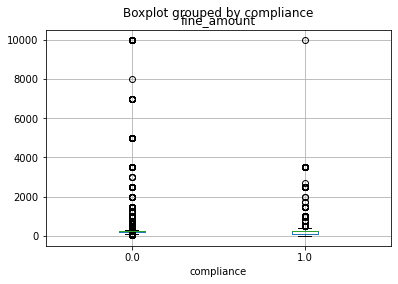

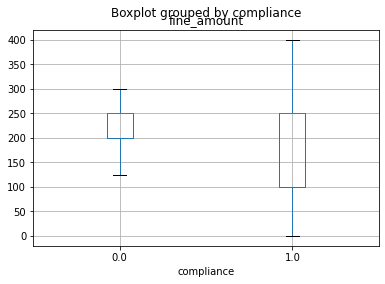

In [25]:

train_simple1.boxplot(column='fine_amount',by='compliance',showfliers=True)

train_simple1.boxplot(column='fine_amount',by='compliance',showfliers=False)


Fist looking at the standard deviation, it tells me that the distribution is mre skewed in the non-compliantcase. It also could be, and we can see that from the box and whisker plots that there are a lot of potential outliers. On the other hand the range and the IQR are much smaller in the non-compliant than in the compliant range. Taht tells me that we should definitely include the fine_amount into the consideration

In [26]:
#now lets tryto group longitude and latittude using k-means clustering
#I need to choose suitable number of clusters. I will use the elbow curve
import matplotlib.pyplot as plt 
%matplotlib inline 

#now lets tryto group longitude and latittude using k-means clustering
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train_simple1[['lat']]
X_axis = train_simple1[['lon']]
score = [kmeans[i].fit(train_simple1[['lat','lon']]).score(train_simple1[['lat','lon']]) for i in range(len(kmeans))]
# Visualize
plt.figure(figsize=(8,6))
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

NameError: name 'KMeans' is not defined

In [ ]:
#another method

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train_simple1[['lon','lat']])
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# So from the graphs above `i can decide to choose 3 clusters. I will do it for the train and test set 
#Then I will merge the new column to my train and tesst set


X=train_simple1[['ticket_id','lat','lon']]



kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[['lat','lon']]) 
X['cluster_label'] = kmeans.fit_predict((X[['lat','lon']]))
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(X[['lat','lon']]) 


X=X[['ticket_id','cluster_label']]
train_simple1=train_simple1.merge(X,how='inner',on='ticket_id')



X1=test[['ticket_id','lat','lon']]
kmeans1 = KMeans(n_clusters = 3, init ='k-means++')
kmeans1.fit(X1[['lat','lon']]) 
X1['cluster_label'] = kmeans1.fit_predict((X1[['lat','lon']]))
centers1 = kmeans1.cluster_centers_ 
labels1 = kmeans1.predict(X1[['lat','lon']]) 



X1=X1[['ticket_id','cluster_label']]
test=test.merge(X1,how='inner',on='ticket_id')

In [ ]:
train_simple1.plot.scatter(x = 'lat', y = 'lon', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=70, alpha=0.5)

I tried different classifiers:Logarithmic, Naive Bayes, Decsion Tree and Random Forest andI used the Gridsearch to find the best parameters. In the end I chose Decision Tree classifier, with min_samples_leaf=10. This resulted in my AUROC being over 0.75 . Here I can presetn onnltrhe ROC curve for the train dataas the complete test data was not accessible to us. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train=train_simple1[['ticket_id','new_viol_code', 'fine_amount','cluster_label']]

y_train=train_simple1['compliance']


X_test=test[['ticket_id','new_viol_code', 'fine_amount','cluster_label']]

dtclf = DecisionTreeClassifier(min_samples_leaf=10).fit(X_train, y_train)

y_pred_prob=dtclf.predict_proba(X_train)

import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.metrics import roc_curve, auc

fpr_dtclf, tpr_dtclf, thresholds_dtclf= roc_curve(y_train,y_pred_prob[:, 1])

roc_auc_lr = auc(fpr_dtclf, tpr_dtclf)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_dtclf, tpr_dtclf, lw=3, label='Decssion tree  ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve ', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [28]:
!conda --version

conda 4.10.0


In [29]:
!python --version

Python 3.7.7


In [30]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.3.0
qtconsole        : 5.0.3
ipython          : 7.22.0
ipykernel        : 5.3.4
jupyter client   : 6.1.12
jupyter lab      : 3.0.11
nbconvert        : 6.0.7
ipywidgets       : 7.6.3
nbformat         : 5.1.3
traitlets        : 5.0.5
